# Analising NiSi XRD data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import scipy.signal as signal
from scipy import sparse
from scipy.sparse.linalg import spsolve

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Latin Modern Roman"],  # must be installed on your system
    "mathtext.fontset": "cm",             # Computer Modern math, matches LaTeX style
    "text.usetex": True,                    # render text via LaTeX
    "text.latex.preamble": r"\usepackage{amsmath, amssymb}"
})

### read file

In [2]:
file_path = r"../Data/XRD/02172026_NiSi2_900grad_.xy"

data = pd.read_csv(file_path, delim_whitespace=True, skiprows=1, header=None, names=['Angle', 'Intensity'])

filename = os.path.basename(file_path)
name = filename.split("_", 1)[1].split("grad")[0]
print(name)

print(data.info())

NiSi2_900
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3001 entries, 0 to 3000
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Angle      3001 non-null   float64
 1   Intensity  3001 non-null   float64
dtypes: float64(2)
memory usage: 47.0 KB
None


C:\Users\lhager\AppData\Local\Temp\ipykernel_14112\2027195362.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, skiprows=1, header=None, names=['Angle', 'Intensity'])


### plot basic spectra starting point

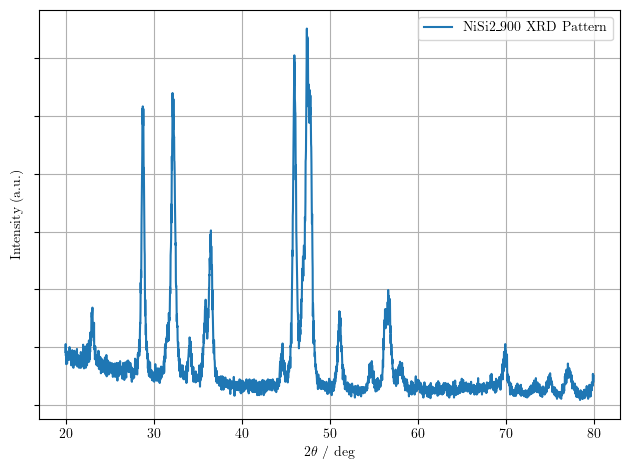

In [34]:
fig, ax = plt.subplots()

ax.plot(data['Angle'], data['Intensity'], label=f'{name} XRD Pattern')

ax.axes.get_yaxis().set_ticklabels([])
plt.xlabel("$2\\theta$ / deg")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.tight_layout()
plt.grid(True)
# plt.savefig(f'../Images/{name}_bessel.pdf', dpi=500)
plt.show()

## data processing
- remove background
- apply filter (Savitzky–Golay)
- normalise
- peak finding

In [4]:
# asymmetric least squares baseline correction
def baseline_als(y, lam=1e5, p=0.01, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w,0,L,L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

### baseline correction

In [5]:
baseline = baseline_als(data['Intensity'].values)
data['Intensity_corr'] = data['Intensity'] - baseline

C:\Users\lhager\AppData\Local\Temp\ipykernel_14112\394510873.py:9: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  z = spsolve(Z, w*y)


### filter

In [7]:
data['filtered'] = signal.savgol_filter(data['Intensity_corr'], window_length=11, polyorder=3)

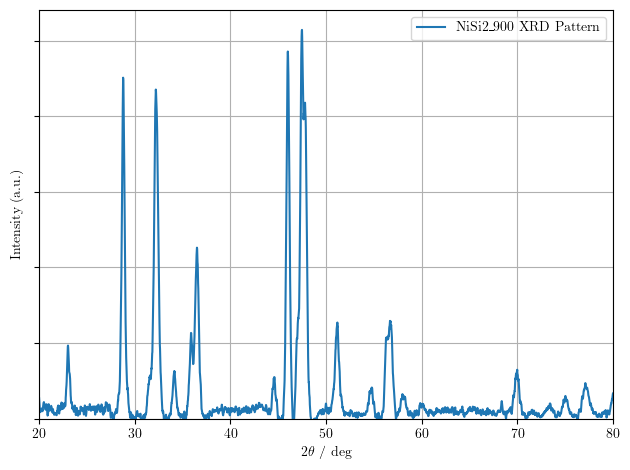

In [33]:
fig, ax = plt.subplots()

ax.plot(data['Angle'], data['filtered'], label=f'{name} XRD Pattern')

ax.axes.get_yaxis().set_ticklabels([])
plt.xlim(20, 80)
plt.gca().set_ylim(bottom=0)
plt.xlabel("$2\\theta$ / deg")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.tight_layout()
plt.grid(True)
# plt.savefig(f'../Images/{name}_bessel.pdf', dpi=500)
plt.show()

### normalise 

In [21]:
data['intensity_norm'] = data['filtered'] / data['filtered'].max()

### find peak position and height

In [30]:
# find peaks using scipy.signal.find_peaks
peaks, properties = signal.find_peaks(data['intensity_norm'], height=0.07, distance=20)
print("Peaks found at angles:", data['Angle'].iloc[peaks].values)

Peaks found at angles: [23.02 28.78 29.26 31.74 32.2  34.12 35.88 36.5  44.58 46.   47.08 47.48
 48.2  50.78 51.18 54.78 56.26 56.68 69.98 77.1 ]


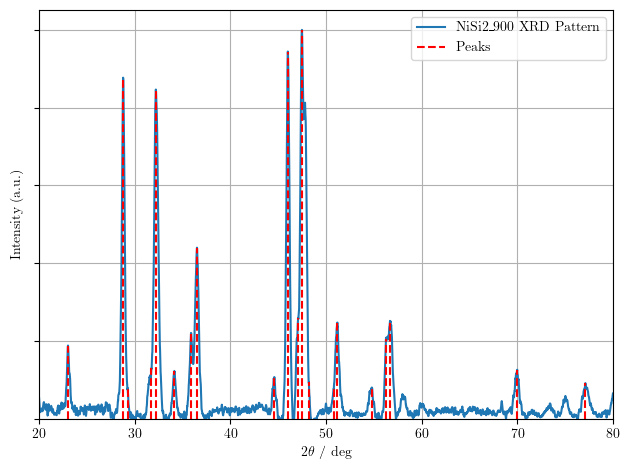

In [32]:
fig, ax = plt.subplots()

ax.plot(data['Angle'], data['intensity_norm'], label=f'{name} XRD Pattern')

plt.vlines(data['Angle'].iloc[peaks].values, ymin=0, ymax=data['intensity_norm'].iloc[peaks], color='red', linestyle='--', label='Peaks')
ax.axes.get_yaxis().set_ticklabels([])
plt.xlim(20, 80)
plt.gca().set_ylim(bottom=0)
plt.xlabel("$2\\theta$ / deg")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.tight_layout()
plt.grid(True)
# plt.savefig(f'../Images/{name}_bessel.pdf', dpi=500)
plt.show()

In [35]:
import plotly.express as px

fig = px.line(data, x="Angle", y="intensity_norm")
fig.show()

ModuleNotFoundError: No module named 'plotly'

### lable peaks

In [ ]:
Ni_peaks = []
Ni2Si_peaks = []
NiSi_peaks = []
NiSi2_peaks = []


